Add Potency column to filtered train set. Train set is from 1_filter folder 

In [3]:
import pandas as pd

# File paths for input files
file1 = "/Users/dolapo/Documents/ERDOS_bootcamp/git_clones/TRPM8-bootcamp-project/3_train_test_split/train_class.csv"  # Path to the first CSV file
file2 = "/Users/dolapo/Documents/ERDOS_bootcamp/git_clones/TRPM8-bootcamp-project/3_train_test_split/descriptors_all.csv"  # Path to the second CSV file

# Output file
output_file = "input/train_class_nofilter_wPotency.csv"

# Read the CSV files into pandas DataFrames
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Ensure only Molecule ChEMBL ID and IC50 columns are used from file2
#df2 = df2[["Molecule ChEMBL ID", "-logIC50"]]  # Adjust "IC50" to the actual column name in file2
df2 = df2[["Molecule ChEMBL ID", "Potency"]]  # Adjust "IC50" to the actual column name in file2

# Merge the two files based on the "Molecule ChEMBL ID" column, keeping all rows in df1
merged_df = pd.merge(df1, df2, on="Molecule ChEMBL ID", how="left")  # Use "left" join to keep all rows from file1

# Save the merged DataFrame to a new CSV file
merged_df.to_csv(output_file, index=False)

print(f"Merged file saved to {output_file}")


Merged file saved to input/train_class_nofilter_wPotency.csv


This script performs Principal Component Analysis (PCA) for dimensionality reduction and feature selection on a the classification training data set of molecular descriptors. It also provides visualization and insights into the data structure. 

Dimensionality Reduction with PCA:
Applies PCA to reduce dimensions while retaining 95% of the variance.
Outputs a scree plot showing the variance explained by each principal component.
Select number of components based on the elblow of the scree plot (e.g. 15) 

PCA Loadings and Feature Selection:
Extracts PCA loadings and sorts them by absolute values.
Dynamically selects features using a threshold based on the mean and standard deviation of absolute loadings.
Saves sorted loadings and selected features to CSV files for training model

Also,converts the PCA-transformed data into a DataFrame and appends Molecule ChEMBL ID and Potency columns.
Saves the reduced-dimensional data to a CSV file (not used further in this project)

Visualizes the pairs of principal components colored by Potency categories (High, Medium, Low).


Explained Variance by Component: [0.32318005 0.12866985 0.11323806 0.04142829 0.03681637 0.02646648
 0.02345687 0.01916802 0.01654736 0.01421779 0.01153112 0.01033289
 0.00972724 0.00921557 0.00814549]
Number of components selected: 15


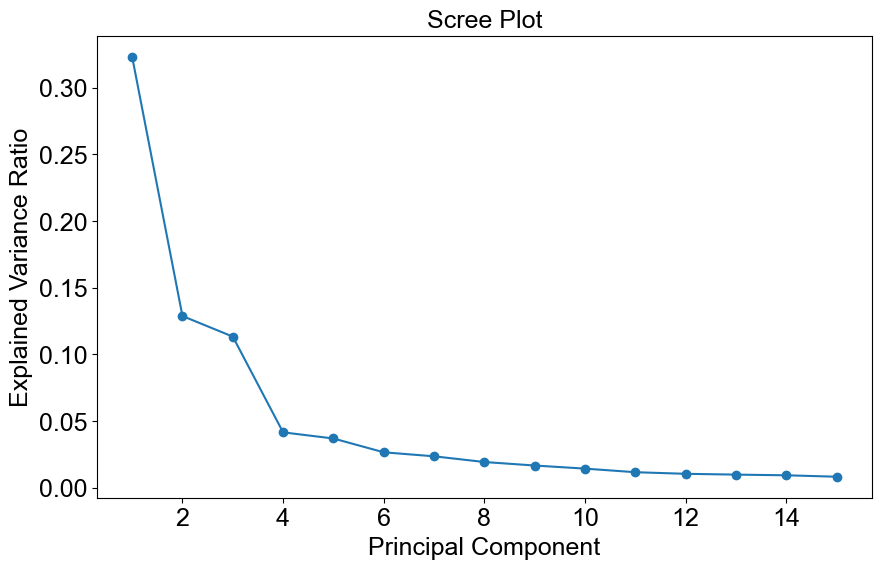

PCA Loadings:
                             PC1       PC2       PC3       PC4       PC5  \
PMI1                   0.044812 -0.027776 -0.019395  0.035270  0.017563   
PMI2                   0.027498  0.066420 -0.025528 -0.021373 -0.014339   
PMI3                   0.033750  0.059493 -0.028317 -0.008702 -0.007280   
Asphericity           -0.022285  0.072835 -0.008449 -0.004012 -0.014565   
Eccentricity          -0.016376  0.064904 -0.012850  0.010651 -0.019545   
...                         ...       ...       ...       ...       ...   
saturatedHeterocycles -0.000256  0.028516  0.005300 -0.039743  0.034058   
satureatedRings        0.011591  0.016164  0.029195 -0.018607  0.036928   
ringCount              0.037872  0.000438 -0.012081  0.012367 -0.044938   
molLogP                0.038002 -0.019651 -0.001035  0.004458  0.043367   
molMR                  0.053150  0.005055 -0.001422  0.007684 -0.038758   

                            PC6       PC7       PC8       PC9      PC10  \
PMI1     

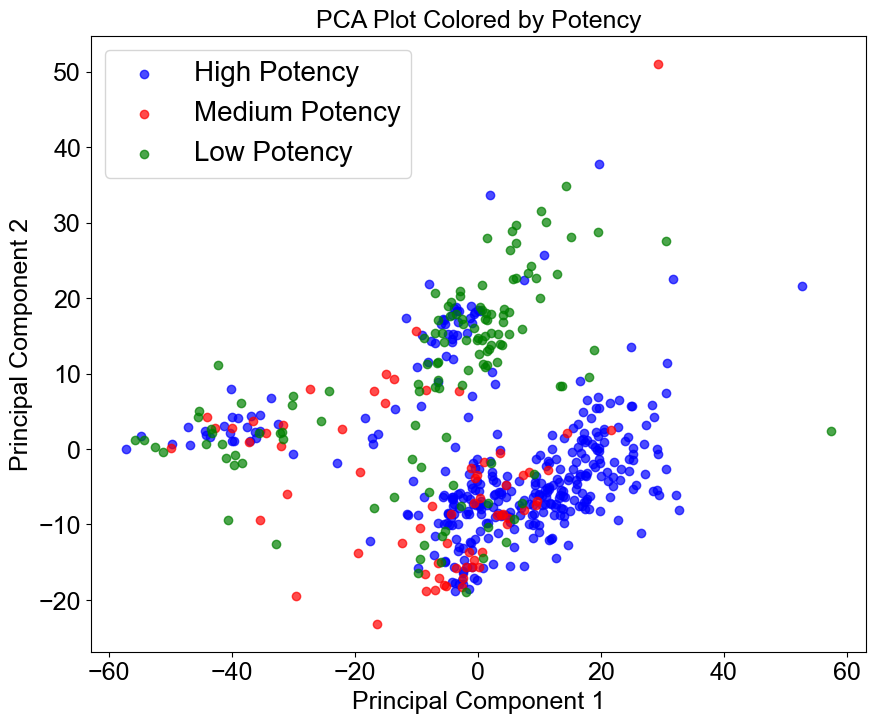

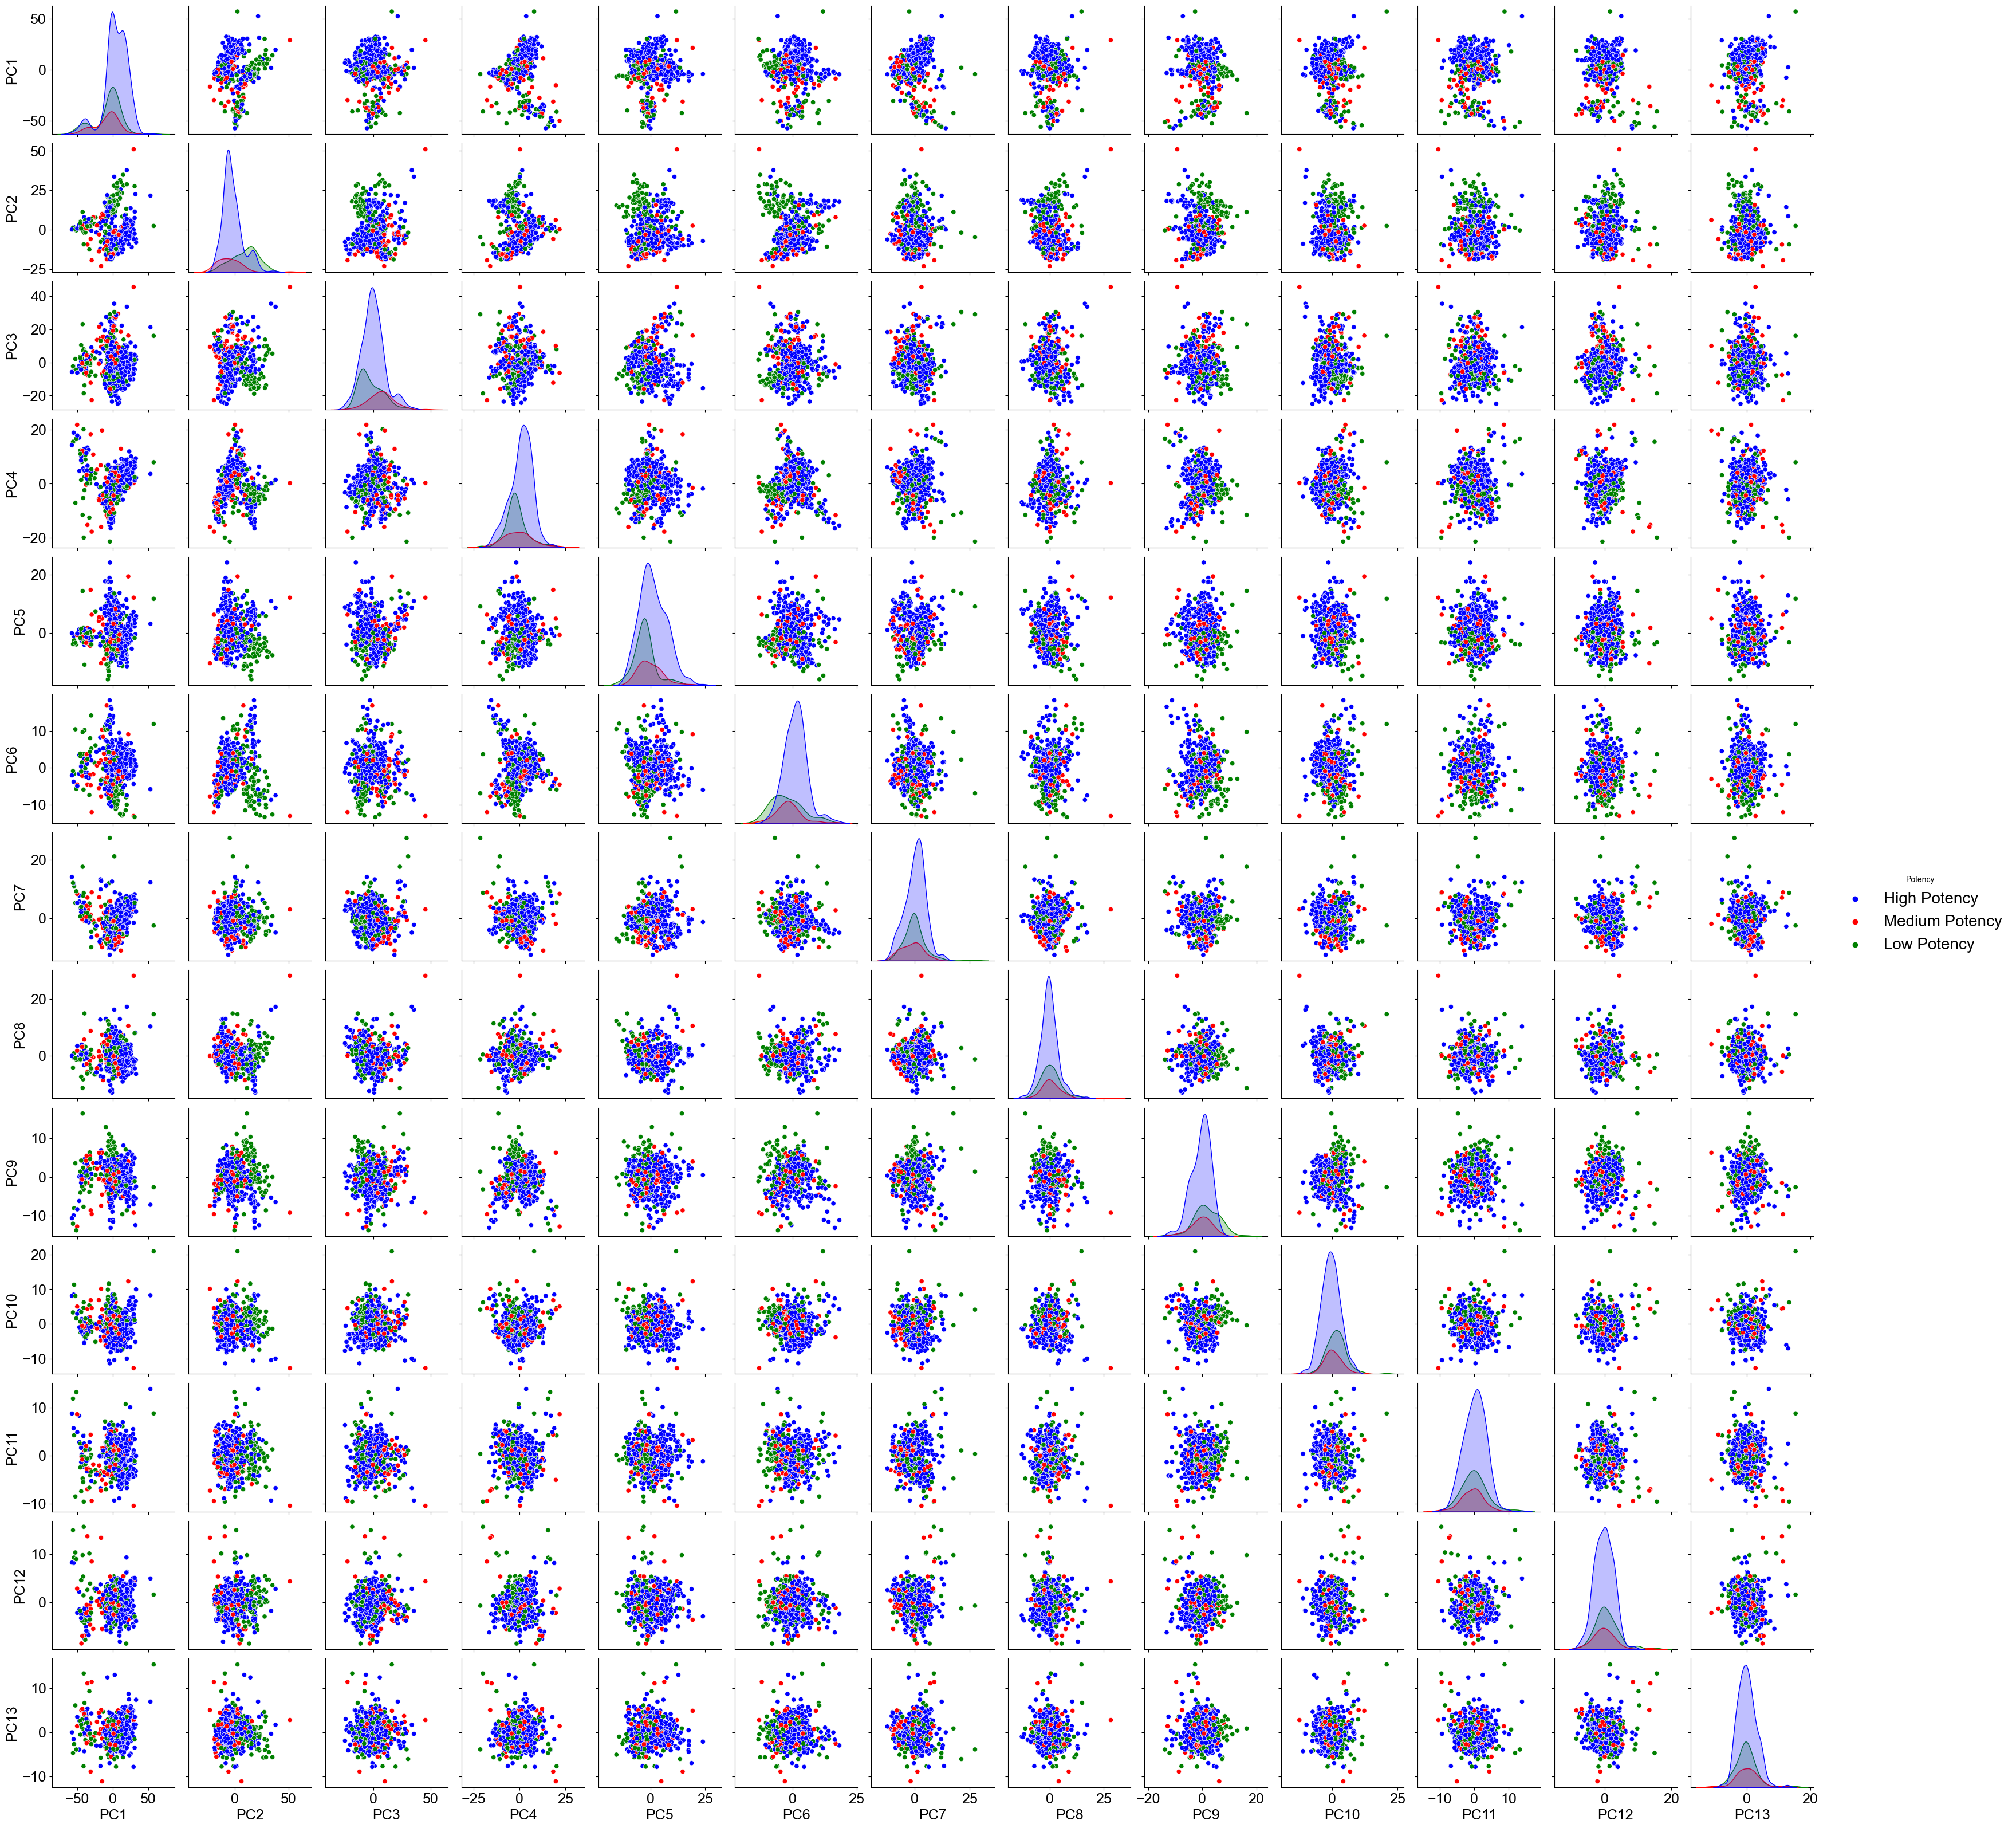

In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure global font settings to Arial
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'
rcParams['axes.titlesize'] = 18  # Font size for titles
rcParams['axes.labelsize'] = 18  # Font size for axis labels
rcParams['xtick.labelsize'] = 18  # Font size for tick labels
rcParams['ytick.labelsize'] = 18  # Font size for tick labels
rcParams['legend.fontsize'] = 20  # Adjust legend font size

# 1. Load data
data = pd.read_csv("input/train_class_nofilter_wPotency.csv")
data['Potency'] = data['Potency'].str.split('\n').str[0].str.strip()

# Separate features and target variable
X = data.drop(columns=['Molecule ChEMBL ID', 'Potency'])  # Replace '-logIC50' with your target variable if needed
y = data['Potency']  # Target variable

# 2. Standardize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Apply PCA to reduce dimensions, keep components that explain 95% of the variance
pcs = PCA(n_components=15)  # Adjust n_components based on your scree plot analysis
X_pcs = pcs.fit_transform(X_scaled)

# 4. Check the variance explained by each component
explained_variance = pcs.explained_variance_ratio_
print("Explained Variance by Component:", explained_variance)
print("Number of components selected:", pcs.n_components_)

# 5. Visualize the explained variance (Scree Plot)
PCA_Scree_plot = '15PCS_scree_plot.png'
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.savefig(PCA_Scree_plot, format='png', dpi=300)
plt.show()

# 6. Inspect PCA Loadings
loadings = pd.DataFrame(pcs.components_.T, index=X.columns, columns=[f'PC{i+1}' for i in range(pcs.n_components_)])
print("PCA Loadings:\n", loadings)

# 7. Sort loadings by absolute values and calculate a dynamic threshold
sorted_pca_abs_sum_loadings = loadings.abs().sum(axis=1).sort_values(ascending=False)

# Calculate mean and standard deviation of the sorted absolute loadings
mean_loading = sorted_pca_abs_sum_loadings.mean()
std_loading = sorted_pca_abs_sum_loadings.std()

# Define threshold as 1 standard deviation above the mean
threshold = mean_loading + std_loading
print(f"Dynamic threshold (mean + 1 std): {threshold}")

# Select features that exceed the threshold
selected_features = sorted_pca_abs_sum_loadings[sorted_pca_abs_sum_loadings > threshold].index.tolist()
print(f"Number of features selected with threshold {threshold}: {len(selected_features)}")

# Save sorted loadings and selected features
sorted_pca_abs_sum_loadings.to_csv("sorted_pca_abs_sum_loadings.csv", header=True)
selected_columns = ['Molecule ChEMBL ID', 'Potency'] + selected_features
train_pca_reduced_class= data[selected_columns]
train_pca_reduced_class.to_csv("train_pca_reduced_class.csv", index=False)

# 8. Convert the PCA-transformed data to a DataFrame
X_pcs_df = pd.DataFrame(X_pcs, columns=[f'PC{i+1}' for i in range(pcs.n_components_)])
X_pcs_df.insert(0, 'Molecule ChEMBL ID', data['Molecule ChEMBL ID'])
X_pcs_df.insert(1, 'Potency', data['Potency'])

# Save the PCA-transformed data
X_pcs_df.to_csv("transformed_reduced_dim_data_with_pcs.csv", index=False)
print("PCA-transformed data with 'Molecule ChEMBL ID' and 'Potency' saved to 'transformed_reduced_dim_data_with_pcs.csv'")

# 9. Create PCA Scatter Plot with Color Coding
colors = {
    "High Potency": 'blue',
    "Medium Potency": 'red',
    "Low Potency": 'green'
}

plt.figure(figsize=(10, 8))
for category, color in colors.items():
    subset = data[data['Potency'] == category]  # Filter data by potency category
    plt.scatter(
        X_pcs_df.loc[subset.index, 'PC1'],  # x-axis
        X_pcs_df.loc[subset.index, 'PC2'],  # y-axis
        c=color,
        label=category,
        alpha=0.7
    )

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Plot Colored by Potency")
plt.legend()
plt.savefig('PCA_scatter_plot.png', dpi=300)
plt.show()

# 10. Pair Plot for Top Principal Components
palette = {
    "High Potency": 'blue',
    "Medium Potency": 'red',
    "Low Potency": 'green'
}

pca_top_components = X_pcs_df.iloc[:, :15]  # Adjust the number of components to include in the pair plot
pca_top_components['Potency'] = data['Potency']  # Add the Potency column to the DataFrame

pair_plot = sns.pairplot(
    pca_top_components,
    hue='Potency',
    palette=palette,
    diag_kind='kde'  # Kernel density estimate for diagonal plots
)
pair_plot.fig.savefig("All_PCs_class_fil.png", format='png', dpi=300)
plt.show()
